### Running with first reward structure, but new NN with 25 outputs

In [1]:
import gym
import gym_warehouse
import numpy as np
import copy

env = gym.make('CartPole-v0')
env.reset()
# env.render()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([ 0.00720762,  0.03779886,  0.04047339, -0.03010234])

In [2]:
env.action_space

Discrete(2)

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

out_dir = 'outdir_cartpole_1/'


import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt

USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

from collections import deque

gamma      = 0.99

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
#         print("STATE: ",state)
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)


def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

# estimated_next_q_state_values=[]
# estimated_next_q_value=[]
    
    
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data.item()
        else:
            action = random.randrange(env.action_space.n)
        return action

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.savefig(out_dir + 'rewards.png')

    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.savefig(out_dir + 'losses.png')
    plt.show()
    
    

def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)    
    next_q_cur_values = current_model(next_state) #next_q_values
    next_q_tar_values = target_model(next_state) #next_q_state_values

    
    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_tar_values.gather(1, torch.max(next_q_cur_values, 1)[1].unsqueeze(1)).squeeze(1)  
    temp = gamma * next_q_value * (1 - done)
    
    expected_q_value = reward + temp
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean() 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [4]:
# current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
# target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)


current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n)

# current_model = torch.load('outdir/current.model')
# current_model.load_state_dict(torch.load('outdir/current.ckpt'))
# # target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)
# target_model = torch.load('outdir/target.model')
# target_model.load_state_dict(torch.load('outdir/target.ckpt'))

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()

optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 1000
replay_buffer = ReplayBuffer(1000)

update_target(current_model, target_model)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 2000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

num_frames = 10000
batch_size = 32

# losses = np.load('outdir/losses.npy')
# all_rewards = np.load('outdir/rewards.npy')

# losses = losses.tolist()
# all_rewards = all_rewards.tolist()
losses=[]
all_rewards=[]
episode_reward = 0

state = env.reset()
# state = state.flatten()

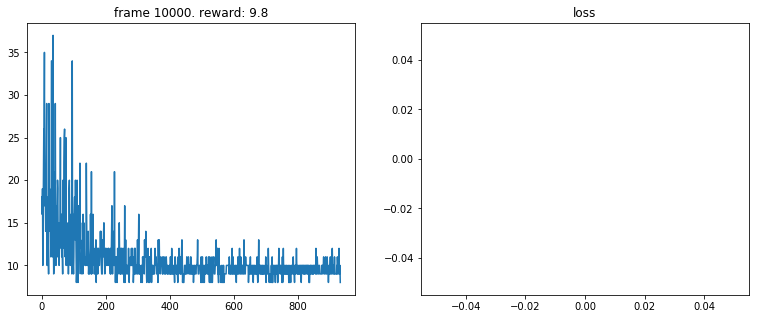

In [5]:

# env.render()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    

    next_state, reward, done, _ = env.step(action)
#     next_state=next_state.flatten()
    
#     print(state)

    replay_buffer.push(state, action, reward, next_state, done)
#     env.render()

    state = next_state
    episode_reward += reward


    if (frame_idx%10000==0):
#         print("EPISODE REWARD: ", episode_reward)
        # SAVING LOSS AND REWARD
        np.save(out_dir + 'losses.npy',np.array(losses))
        np.save(out_dir + 'rewards.npy',np.array(all_rewards))

#         SAVING CHECKPOINTS
        torch.save(current_model.state_dict(),out_dir + 'current.ckpt'.format(frame_idx))
        torch.save(target_model.state_dict(),out_dir + 'target.ckpt'.format(frame_idx))

#         SAVING MODELS
        torch.save(current_model,out_dir + 'current.model')
        torch.save(target_model,out_dir + 'target.model')

    if frame_idx % 10000==0:
        print('Frame: ',frame_idx)
        print("Episode Reward: {}".format(episode_reward))
#         print("ALL REWARDS: {}".format(sum(all_rewards)))
        
    if done:
        state = env.reset()
#         state = state.flatten()
        all_rewards.append(episode_reward)
#         print("Episode Reward: {}".format(episode_reward))
#         print("Episode Reward When Done: {}".format(episode_reward))
        episode_reward = 0




    if (len(replay_buffer) > replay_initial):
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())

    if frame_idx % 2000 == 0:
        plot(frame_idx, all_rewards, losses)

    if frame_idx % 1500 == 0:
        update_target(current_model, target_model)